In [295]:
import os
import requests
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

import datetime as dt
import dateparser

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

# Téléchargement des données Classement

In [2]:
%%time
#NO NEED TO REDOWNLOAD - ALREADY DONE ONCE

#######################################################
## Téléchargement des fichiers .xlsx depuis le site. ##
#######################################################

"""response = requests.get(f'https://www.vendeeglobe.org/fr/classement')
soup = BeautifulSoup(response.content)
dates = soup.find('select', {'class':"form__input m--select onsubmit-rank"}).findAll('option')
labels =  sorted([dates[i].get('value') for i in range(len(dates))][1:])
labels = labels[2:labels.index("20210127_140000")]

for date in labels:
    dls = "https://www.vendeeglobe.org/" + "download-race-data/vendeeglobe_" + str(date) + ".xlsx"
    resp = requests.get(dls)
    with open('Classements/'+str(date)+'.xlsx', 'wb') as output:
        #On n'écrit plus rien. 
        output.write(resp.content)"""

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.86 µs


'response = requests.get(f\'https://www.vendeeglobe.org/fr/classement\')\nsoup = BeautifulSoup(response.content)\ndates = soup.find(\'select\', {\'class\':"form__input m--select onsubmit-rank"}).findAll(\'option\')\nlabels =  sorted([dates[i].get(\'value\') for i in range(len(dates))][1:])\nlabels = labels[2:labels.index("20210127_140000")]\n\nfor date in labels:\n    dls = "https://www.vendeeglobe.org/" + "download-race-data/vendeeglobe_" + str(date) + ".xlsx"\n    resp = requests.get(dls)\n    with open(\'Classements/\'+str(date)+\'.xlsx\', \'wb\') as output:\n        #On n\'écrit plus rien. \n        output.write(resp.content)'

In [3]:
#############################################
## Fonction pour réparer les xlsx récupées ##
#############################################

import tempfile
from zipfile import ZipFile
import shutil
import os
from fnmatch import fnmatch
import re

def change_in_zip(file_name, name_filter, change):
    tempdir = tempfile.mkdtemp()
    try:
        tempname = os.path.join(tempdir, 'new.zip')
        with ZipFile(file_name, 'r') as r, ZipFile(tempname, 'w') as w:
            for item in r.infolist():
                data = r.read(item.filename)           
                data = change(data)
                w.writestr(item, data)
        shutil.move(tempname, file_name)
    finally:
        shutil.rmtree(tempdir)


In [4]:
#########################################
## Liste avec les chemins des fichiers ##
#########################################

directory = r'Classements/'
paths = []
for entry in os.scandir(directory):
    if (entry.path.endswith(".xlsx")) & ~(entry.path.startswith("Classements/~")) : 
        paths.append(entry.path)
paths = sorted(paths)
paths[:20]

['Classements/20201108_150000.xlsx',
 'Classements/20201108_170000.xlsx',
 'Classements/20201108_210000.xlsx',
 'Classements/20201109_040000.xlsx',
 'Classements/20201109_080000.xlsx',
 'Classements/20201109_110000.xlsx',
 'Classements/20201109_140000.xlsx',
 'Classements/20201109_170000.xlsx',
 'Classements/20201109_210000.xlsx',
 'Classements/20201110_040000.xlsx',
 'Classements/20201110_080000.xlsx',
 'Classements/20201110_110000.xlsx',
 'Classements/20201110_140000.xlsx',
 'Classements/20201110_170000.xlsx',
 'Classements/20201110_210000.xlsx',
 'Classements/20201111_040000.xlsx',
 'Classements/20201111_080000.xlsx',
 'Classements/20201111_110000.xlsx',
 'Classements/20201111_140000.xlsx',
 'Classements/20201111_170000.xlsx']

In [5]:
%%time
#############################
## Réparation des fichiers ##
#############################

for path in paths:
    change_in_zip(path, 
              name_filter='xl/styles.xml', # the problematic property is found in the style xml files
              change=lambda d: re.sub(b'xxid="\d*"', b"", d))

CPU times: user 1.77 s, sys: 260 ms, total: 2.03 s
Wall time: 2.34 s


In [6]:
##############################################################
## Fonction qui convertit les coordonnées en format décimal ##
##############################################################

def dms2dec(deg, mn, sec):
    return deg + mn / 60 + sec / 3600

In [26]:
###################################################################
## Définition de la fonction qui acquiert et nettoie les données ##
###################################################################

def Clean(path):

    # Get the dataframe from the path
    df = pd.read_excel(path, header=[3,4], nrows=25)

    # Get the timestamp of the reading
    title = pd.read_excel(path, header=1, nrows=1)['Unnamed: 1'].str.extract('Classement du (.*) FR')
    stamp = dateparser.parse(title[0][0])
    df['Stamp'] = stamp

    # Cleaning the data
    df['Rank'] = df['Rang\nRank']['Unnamed: 1_level_1'].astype(int)
    df[['Nat', 'Voile']] = df['Nat. / Voile\nNat. / Sail']['Unnamed: 2_level_1'].str.strip('\n').str.replace('\nFRA','').str.split(' ', expand=True)
    df[['Skipper', 'Bateau']] = df['Skipper / Bateau\nSkipper / crew']['Unnamed: 3_level_1'].str.split('\n', expand=True)

    # Position
    df['Position_Hour'] = df['Skipper / Bateau\nSkipper / crew']['Heure FR\nHour FR'].str.split(' FR\n', expand=True)[0].str.replace(':','H') + 'MIN'
    df['Position_Hour'] = pd.to_timedelta(df['Position_Hour'])

    df['Position_Longitude'] = df['Skipper / Bateau\nSkipper / crew']['Longitude\nLongitude']
    df['Position_Latitude'] = df['Skipper / Bateau\nSkipper / crew']['Latitude\nLatitude']

    A = df['Position_Longitude'].str.extract("(.*)°(..).(..)'.").astype(int)
    A['D'] =df['Position_Longitude'].str.extract(".*'(.)").astype(str)
    df['Position_Longitude_decimale'] = dms2dec(A[0],A[1],A[2])
    df['Position_Longitude_decimale'] = np.where(A['D'] == 'W', -df['Position_Longitude_decimale'], df['Position_Longitude_decimale'])

    B = df['Position_Latitude'].str.extract("(.*)°(..).(..)'.").astype(int)
    B['D'] = df['Position_Latitude'].str.extract(".*'(.)").astype(str)
    df['Position_Latitude_decimale'] = dms2dec(B[0],B[1],B[2])
    df['Position_Latitude_decimale'] = np.where(B['D'] == 'S', -df['Position_Latitude_decimale'], df['Position_Latitude_decimale'])

    # Clean des Colonnes de 'Depuis 30 minutes'
    df["Depuis 30 minutes_Cap"] = df['Depuis 30 minutes\nSince 30 minutes']['Cap\nHeading'].str.strip('°').astype(float)
    df["Depuis 30 minutes_Vitesse"] = df['Depuis 30 minutes\nSince 30 minutes']['Vitesse\nSpeed'].str.strip(' kts').astype(float)
    df["Depuis 30 minutes_VMG"] = df['Depuis 30 minutes\nSince 30 minutes']['VMG\nVMG'].str.strip(' kts').astype(float)
    df["Depuis 30 minutes_Distance"] = df['Depuis 30 minutes\nSince 30 minutes']['Distance\nDistance'].str.strip(' nm').astype(float)

    # Clean des Colonnes de 'Depuis le dernier classement'
    df["Depuis le dernier classement_Cap"] = df['Depuis le dernier classement\nSince the the last report']['Cap\nHeading']\
    .str.strip('°').astype(float)
    df["Depuis le dernier classement_Vitesse"] = df['Depuis le dernier classement\nSince the the last report']['Vitesse\nSpeed']\
    .str.strip(' kts').astype(float)
    df["Depuis le dernier classement_VMG"] = df['Depuis le dernier classement\nSince the the last report']['VMG\nVMG']\
    .str.strip(' kts').astype(float)
    df["Depuis le dernier classement_Distance"] = df['Depuis le dernier classement\nSince the the last report']['Distance\nDistance']\
    .str.strip(' nm').astype(float)

    # Clean des Colonnes de 'Depuis 24 heures'
    df["Depuis 24 heures_Cap"] = df['Depuis 24 heures\nSince 24 hours']['Cap\nHeading'].str.strip('°').astype(float)
    df["Depuis 24 heures_Vitesse"] = df['Depuis 24 heures\nSince 24 hours']['Vitesse\nSpeed'].str.strip(' kts').astype(float)
    df["Depuis 24 heures_VMG"] = df['Depuis 24 heures\nSince 24 hours']['VMG\nVMG'].str.strip(' kts').astype(float)
    df["Depuis 24 heures_Distance"] = df['Depuis 24 heures\nSince 24 hours']['Distance\nDistance'].str.strip(' nm').astype(float)

    df['DTF_'] = df['DTF']['Unnamed: 19_level_1'].str.strip(' nm').astype(float)
    df['DTL_'] = df['DTL']['Unnamed: 20_level_1'].str.strip(' nm').astype(float)

    # Rearranging columns 
    columns = ['Stamp', 'Rank','Nat', 'Voile', 'Skipper', 'Bateau','Position_Hour','Position_Longitude',\
               'Position_Latitude','Position_Longitude_decimale','Position_Latitude_decimale',\
              "Depuis 30 minutes_Cap",'Depuis 30 minutes_Vitesse','Depuis 30 minutes_VMG','Depuis 30 minutes_Distance',\
              "Depuis le dernier classement_Cap","Depuis le dernier classement_Vitesse","Depuis le dernier classement_VMG",'Depuis le dernier classement_Distance',\
              "Depuis 24 heures_Cap","Depuis 24 heures_Vitesse","Depuis 24 heures_VMG","Depuis 24 heures_Distance",\
              "DTF_","DTL_"]
    df = df[columns]

    return df


In [27]:
%%time
df = Clean(paths[0])
i=0
for path in paths:
    i+=1
    df = df.append(Clean(path))
    if i % 50 == 0: print(i)
    #print(i)
df.head()

/opt/anaconda3/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning:

The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html



50
100
150
200
250
300
350
400
450
CPU times: user 53.2 s, sys: 487 ms, total: 53.7 s
Wall time: 54.4 s


,Stamp,Rank,Nat,Voile,Skipper,Bateau,Position_Hour,Position_Longitude_decimale,Position_Latitude_decimale,Depuis 30 minutes_Cap,...,Depuis le dernier classement_Cap,Depuis le dernier classement_Vitesse,Depuis le dernier classement_VMG,Depuis le dernier classement_Distance,Depuis 24 heures_Cap,Depuis 24 heures_Vitesse,Depuis 24 heures_VMG,Depuis 24 heures_Distance,DTF_,DTL_
,,,,,,,,,,,...,,,,,,,,,,
0,2020-11-08 17:00:00,1,FRA,8,Jérémie Beyou,Charal,0 days 17:00:00,-2.597222,46.353333,268.0,...,262.0,21.1,19.7,31.7,254.0,1.4,1.4,34.5,24265.1,0.0
1,2020-11-08 17:00:00,2,FRA,79,Charlie Dalin,APIVIA,0 days 17:00:00,-2.529167,46.296111,262.0,...,357.0,0.0,0.0,2782.5,247.0,1.4,1.4,32.9,24265.8,0.7
2,2020-11-08 17:00:00,3,GBR,99,Alex Thomson,Hugo Boss,0 days 17:00:00,-2.535000,46.318889,263.0,...,257.0,19.9,19.1,29.9,249.0,1.4,1.3,32.7,24266.3,1.2
3,2020-11-08 17:00:00,4,FRA,59,Thomas Ruyant,LinkedOut,0 days 17:00:00,-2.541389,46.329167,266.0,...,260.0,19.9,18.9,29.9,251.0,1.4,1.3,32.7,24266.3,1.2
4,2020-11-08 17:00:00,5,MON,10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,0 days 17:00:00,-2.500833,46.306111,263.0,...,257.0,19.0,18.2,28.2,248.0,1.3,1.3,31.5,24267.3,2.2


In [21]:
df.shape

(12025, 25)

In [259]:
###############################################
## Saving the df to pickle for faster access ##
###############################################

df = df.set_index('Stamp').sort_index()
df.columns = df.columns.droplevel(1)
path = 'Classements.pkl'
df.to_pickle(path)

In [297]:
df = pd.read_pickle('Classements.pkl')
df.head()

,Rank,Nat,Voile,Skipper,Bateau,Position_Hour,Position_Longitude,Position_Latitude,Position_Longitude_decimale,Position_Latitude_decimale,...,Depuis le dernier classement_Cap,Depuis le dernier classement_Vitesse,Depuis le dernier classement_VMG,Depuis le dernier classement_Distance,Depuis 24 heures_Cap,Depuis 24 heures_Vitesse,Depuis 24 heures_VMG,Depuis 24 heures_Distance,DTF_,DTL_
Stamp,,,,,,,,,,,,,,,,,,,,,
2020-11-08 17:00:00,1,FRA,8,Jérémie Beyou,Charal,0 days 17:00:00,02°35.50'W,46°20.72'N,-2.597222,46.353333,...,262.0,21.1,19.7,31.7,254.0,1.4,1.4,34.5,24265.1,0.0
2020-11-08 17:00:00,2,FRA,79,Charlie Dalin,APIVIA,0 days 17:00:00,02°31.45'W,46°17.46'N,-2.529167,46.296111,...,357.0,0.0,0.0,2782.5,247.0,1.4,1.4,32.9,24265.8,0.7
2020-11-08 17:00:00,3,GBR,99,Alex Thomson,Hugo Boss,0 days 17:00:00,02°31.66'W,46°18.68'N,-2.535000,46.318889,...,257.0,19.9,19.1,29.9,249.0,1.4,1.3,32.7,24266.3,1.2
2020-11-08 17:00:00,4,FRA,59,Thomas Ruyant,LinkedOut,0 days 17:00:00,02°32.29'W,46°19.45'N,-2.541389,46.329167,...,260.0,19.9,18.9,29.9,251.0,1.4,1.3,32.7,24266.3,1.2
2020-11-08 17:00:00,5,MON,10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,0 days 17:00:00,02°29.63'W,46°18.22'N,-2.500833,46.306111,...,257.0,19.0,18.2,28.2,248.0,1.3,1.3,31.5,24267.3,2.2


# DONNES SUR LES BATEAUX

In [262]:
###################################################################################
## Définition de la fonction qui acquiert et nettoie les données sur les bateaux ##
###################################################################################

def GetnClean(path):

    response = requests.get(path)

    soup = BeautifulSoup(response.content)
    Boats_info = soup.findAll('div', {'class':"boats-list__infos"})
    Boat_name = []
    Skipper_name = []
    for boat in Boats_info : 
        Boat_name.append(boat.find('h3').text)
        Skipper_name.append(boat.find('span').text)

    soup = BeautifulSoup(response.content)
    boats = soup.findAll('ul', {'class':"boats-list__popup-specs-list"})
    Boats = {}
    for boat in boats:
        boat = boat.findAll('li')
        name = boat[0].text.split(' : ')[1]
        Boats[name] = {}
        for line in boat[1:]:
            key = line.text.split(' : ')[0]
            val = line.text.split(' : ')[1]

            Boats[name][key] = val
    Boats = pd.DataFrame(Boats).T
    Boats['Date de lancement'] = Boats['Date de lancement'].apply(dateparser.parse)
    Boats['Longueur (m)'] = Boats['Longueur'].str.strip(' m').str.replace(',','.').astype('float')
    Boats['Largeur (m)'] = Boats['Largeur'].str.strip(' m').str.replace(',','.').astype('float')
    Boats["Tirant d'eau (m)"] = Boats["Tirant d'eau"].str.strip(' m').str.replace(',','.').astype('float')
    Boats["Déplacement (poids) (T)"] = Boats["Déplacement (poids)"].str.strip(' t').str.strip(' tonnes')\
    .str.replace('[a-zA-Z]', '0', regex=True).str.replace(',','.').astype(float)
    Boats["Hauteur mât (m)"] = Boats["Hauteur mât"].str.strip(' m').str.replace(',','.').astype('float')
    Boats["Surface de voiles au près (m2)"] = Boats["Surface de voiles au près"].str.strip(' m2').str.strip(' m²').str.replace(',','.').astype('float')
    Boats["Surface de voiles au portant (m2)"] = Boats["Surface de voiles au portant"].str.strip(' m2').str.strip(' m²').str.replace(',','.').astype('float')
    Boats['Skipper'] = Skipper_name
    Boats['Skipper'] = Boats['Skipper'].apply(lambda x : str.title(x)).str.replace('  ',' ')
    Boats = Boats.replace("Sam Davies","Samantha Davies")
    Boats = Boats.replace("Arnaud Boissières","Arnaud Boissieres")
    Boats['Bateau2'] = Boat_name


    Boats.columns
    columns = ['Skipper','Bateau2','Anciens noms du bateau', 'Architecte', 'Chantier', 'Date de lancement',
           'Longueur (m)', 'Largeur (m)', "Tirant d'eau (m)", 'Déplacement (poids) (T)',
           'Nombre de dérives', 'Hauteur mât (m)', 'Voile quille',
           'Surface de voiles au près (m2)', 'Surface de voiles au portant (m2)']
    Boats = Boats[columns]

    Boats["Anciens noms du bateau"] = Boats["Anciens noms du bateau"].fillna('')
    Boats["Architecte"] = Boats["Architecte"].fillna('')
    Boats["Voile quille"] = Boats["Voile quille"].fillna('')
    
    return Boats


In [298]:
Boats = GetnClean('https://www.vendeeglobe.org/fr/glossaire')

/opt/anaconda3/lib/python3.8/site-packages/dateparser/date_parser.py:35: PytzUsageWarning:

The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html



In [302]:
#####################################################
## Saving the Boats df to pickle for faster access ##
#####################################################

path = 'Boats.pkl'
Boats.to_pickle(path)

In [303]:
Boats = pd.read_pickle('Boats.pkl')
Boats.head()

,Skipper,Bateau2,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids) (T),Nombre de dérives,Hauteur mât (m),Voile quille,Surface de voiles au près (m2),Surface de voiles au portant (m2)
FRA 56,Fabrice Amedeo,NEWREST - ART & FENÊTRES,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,2015-08-01,18.28,5.85,4.5,7.0,foils,29.0,monotype,320.0,570.0
FRA 49,Romain Attanasio,PURE - Best Western®,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),2007-03-08,18.28,5.80,4.5,9.0,2,28.0,acier forgé,80.0,560.0
FRA72,Alexia Barrier,TSE - 4MYPLANET,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,1998-03-01,18.28,5.54,4.5,9.0,2,29.0,acier,60.0,580.0
17,Yannick Bestaven,Maître CoQ IV,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,2015-03-12,18.28,5.80,4.5,8.0,foils,29.0,acier mécano soudé,310.0,550.0
08,Jérémie Beyou,CHARAL,,VPLP,CDK Technologies,2018-08-18,18.28,5.85,4.5,8.0,foils,29.0,acier,320.0,600.0


In [304]:
################################################
## Merge the Classements and Boats dataframes ##
################################################

df = df.reset_index()
df_merge = df.merge(Boats, on="Skipper", how='left')
df_merge = df_merge.set_index('Stamp').sort_index()

# Save to pickle
path = 'Merged.pkl'
df_merge.to_pickle(path)

In [305]:
Merged = pd.read_pickle('Merged.pkl')
Merged.head()

,index,Rank,Nat,Voile,Skipper,Bateau,Position_Hour,Position_Longitude,Position_Latitude,Position_Longitude_decimale,...,Date de lancement,Longueur (m),Largeur (m),Tirant d'eau (m),Déplacement (poids) (T),Nombre de dérives,Hauteur mât (m),Voile quille,Surface de voiles au près (m2),Surface de voiles au portant (m2)
Stamp,,,,,,,,,,,,,,,,,,,,,
2020-11-08 17:00:00,0,1,FRA,8,Jérémie Beyou,Charal,0 days 17:00:00,02°35.50'W,46°20.72'N,-2.597222,...,2018-08-18,18.28,5.85,4.5,8.0,foils,29.0,acier,320.0,600.0
2020-11-08 17:00:00,1,2,FRA,79,Charlie Dalin,APIVIA,0 days 17:00:00,02°31.45'W,46°17.46'N,-2.529167,...,2019-08-05,18.28,5.85,4.5,8.0,foils,29.0,acier,350.0,560.0
2020-11-08 17:00:00,2,3,GBR,99,Alex Thomson,Hugo Boss,0 days 17:00:00,02°31.66'W,46°18.68'N,-2.535000,...,2019-08-15,18.28,5.40,4.5,7.7,foils,29.0,acier forgé,330.0,630.0
2020-11-08 17:00:00,3,4,FRA,59,Thomas Ruyant,LinkedOut,0 days 17:00:00,02°32.29'W,46°19.45'N,-2.541389,...,2019-09-03,18.28,5.85,4.5,8.0,foils,29.0,acier forgé,350.0,560.0
2020-11-08 17:00:00,4,5,MON,10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,0 days 17:00:00,02°29.63'W,46°18.22'N,-2.500833,...,2015-08-07,18.28,5.70,4.5,7.6,foils,29.0,acier,90.0,490.0


In [306]:
Merged["Nombre de dérives"].unique()

array(['foils', 'foiler', '2', '2 asymétriques'], dtype=object)

In [314]:
Merged.loc[Merged["Nombre de dérives"] == "foiler", "Skipper"].unique()

array(['Sébastien Simon'], dtype=object)

## Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.

### 1. Correlation entre le Rank et la VMG depuis le dernier classement

Correlation entre le rang et la vitesse VMG depuis le dernier classement:

- Coefficient : -0.1113
- Intercept : 13.3168
- Score R2 : 0.9176



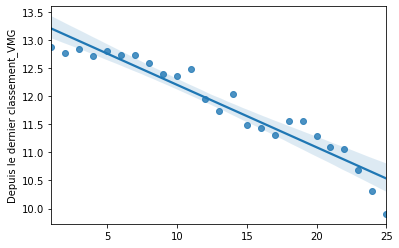

In [112]:
from sklearn.linear_model import LinearRegression

VMG_Rank_last_rank = pd.DataFrame(df.groupby('Rank')['Depuis le dernier classement_VMG'].mean())
Rank = VMG_Rank_last_rank.index.values.reshape(-1,1)
VMG_last_rank = VMG_Rank_last_rank["Depuis le dernier classement_VMG"]

linreg = LinearRegression(fit_intercept=True)
linreg.fit(Rank, VMG_last_rank)
VMG_pred = linreg.predict(Rank)

coef = np.round(linreg.coef_[0],4)
intercept = np.round(linreg.intercept_,4)
r2 = np.round(sklearn.metrics.r2_score(VMG_last_rank, VMG_pred),4)

print("Correlation entre le rang et la vitesse VMG depuis le dernier classement:\n\n\
- Coefficient : {}\n\
- Intercept : {}\n\
- Score R2 : {}\n"\
      .format(coef, intercept, r2))

sns.regplot(x = Rank, y = VMG_last_rank, data = VMG_Rank_last_rank);

### 2. Correlation entre le Rank et la VMG depuis 30mn

Correlation entre le rang et la vitesse VMG depuis 30 minutes:

- Coefficient : -0.1088
- Intercept : 13.2395
- Score R2 : 0.8945



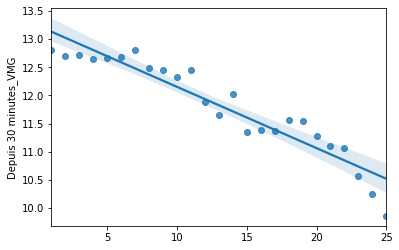

In [115]:
from sklearn.linear_model import LinearRegression

VMG_Rank_last_30mn = pd.DataFrame(df.groupby('Rank')['Depuis 30 minutes_VMG'].mean())
Rank = VMG_Rank_last_30mn.index.values.reshape(-1,1)
VMG_last_30mn = VMG_Rank_last_30mn["Depuis 30 minutes_VMG"]

linreg = LinearRegression(fit_intercept=True)
linreg.fit(Rank, VMG_last_30mn)
VMG_pred = linreg.predict(Rank)

coef = np.round(linreg.coef_[0],4)
intercept = np.round(linreg.intercept_,4)
r2 = np.round(sklearn.metrics.r2_score(VMG_last_30mn, VMG_pred),4)

print("Correlation entre le rang et la vitesse VMG depuis 30 minutes:\n\n\
- Coefficient : {}\n\
- Intercept : {}\n\
- Score R2 : {}\n"\
      .format(coef, intercept, r2))

sns.regplot(x = Rank, y = VMG_last_30mn, data = VMG_Rank_last_30mn);

### 3. Correlation entre le Rank et la VMG depuis 24h

Correlation entre le rang et la vitesse VMG depuis 24 heures:

- Coefficient : -0.1141
- Intercept : 13.1535
- Score R2 : 0.9271



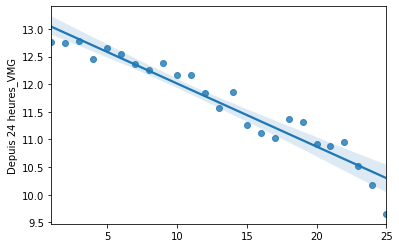

In [116]:
from sklearn.linear_model import LinearRegression

VMG_Rank_last_24h = pd.DataFrame(df.groupby('Rank')['Depuis 24 heures_VMG'].mean())
Rank = VMG_Rank_last_24h.index.values.reshape(-1,1)
VMG_last_24h = VMG_Rank_last_24h["Depuis 24 heures_VMG"]

linreg = LinearRegression(fit_intercept=True)
linreg.fit(Rank, VMG_last_24h)
VMG_pred = linreg.predict(Rank)

coef = np.round(linreg.coef_[0],4)
intercept = np.round(linreg.intercept_,4)
r2 = np.round(sklearn.metrics.r2_score(VMG_last_24h, VMG_pred),4)

print("Correlation entre le rang et la vitesse VMG depuis 24 heures:\n\n\
- Coefficient : {}\n\
- Intercept : {}\n\
- Score R2 : {}\n"\
      .format(coef, intercept, r2))

sns.regplot(x = Rank, y = VMG_last_24h, data = VMG_Rank_last_24h);

## Visualisation des distances cumulées parcourues par les 5 skippers gagants.

In [156]:
Skippers = ['Charlie Dalin', 'Louis Burton', 'Boris Herrmann', 'Thomas Ruyant', 'Yannick Bestaven']

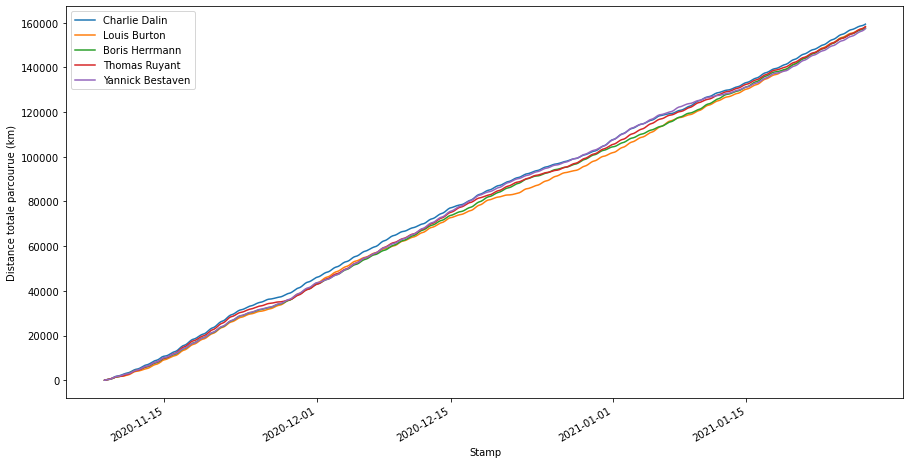

In [321]:
fig = plt.subplots(1, figsize=(15,8))

for skipper in Skippers[:5]:
    skip = Merged.loc[(Merged['Skipper'] == skipper),"Depuis 24 heures_Distance"]
    skip.cumsum().plot(label = skipper)

plt.ylabel('Distance totale parcourue (km)')
plt.legend();

## Visualisation sur une carte des parcours des 5 skippers gagants.

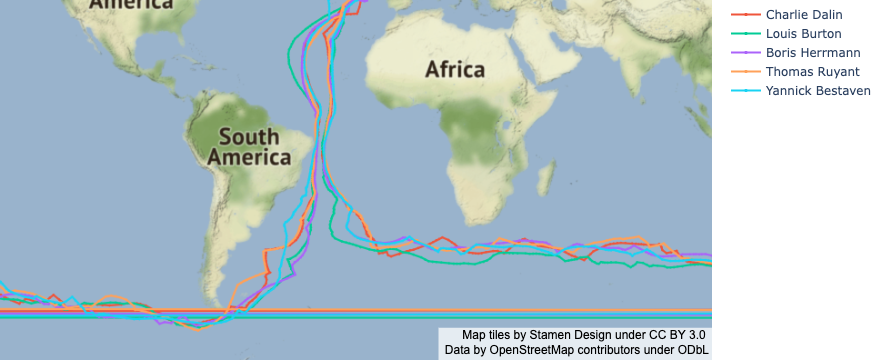

In [500]:
import plotly.graph_objects as go

fig = go.Figure(go.Scattermapbox())
i=0
for skipper in Skippers: 
    sk = df.loc[df['Skipper'] == skipper]
    stamp = sk.index

    fig.add_trace(go.Scattermapbox(
        
        mode = "markers+lines",
        lon = sk["Position_Longitude_decimale"],
        lat = sk["Position_Latitude_decimale"],
        name = skipper,
        marker = {'size': 3},
                text= stamp ))
    i+=1
     

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': {'lon': 10, 'lat': 10},
        'style': "stamen-terrain",
        'center': {'lon': -20, 'lat': -20},
        'zoom': 1})

fig.show()

## TimeSeries : Visualisation de l'évolution du rang au fil de la course des 5 skippers gagants.

In [156]:
Skippers = ['Charlie Dalin', 'Louis Burton', 'Boris Herrmann', 'Thomas Ruyant', 'Yannick Bestaven']

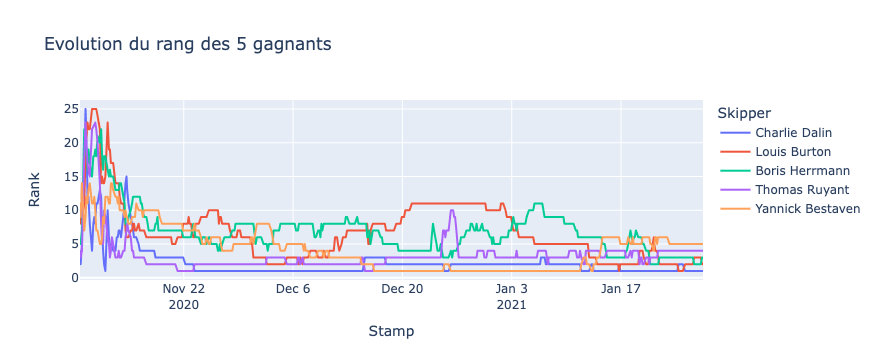

In [543]:
sk = Merged.loc[Merged['Skipper'] == Skippers[0]]
for skipper in Skippers[1:]:
    sk2 = Merged.loc[Merged['Skipper'] == skipper]
    sk = sk.append(sk2)
px.line(data_frame = sk, x = sk.index, y = 'Rank', color='Skipper', title="Evolution du rang des 5 gagnants")

In [510]:
Merged.columns

Index(['index', 'Rank', 'Nat', 'Voile', 'Skipper', 'Bateau', 'Position_Hour',
       'Position_Longitude', 'Position_Latitude',
       'Position_Longitude_decimale', 'Position_Latitude_decimale',
       'Depuis 30 minutes_Cap', 'Depuis 30 minutes_Vitesse',
       'Depuis 30 minutes_VMG', 'Depuis 30 minutes_Distance',
       'Depuis le dernier classement_Cap',
       'Depuis le dernier classement_Vitesse',
       'Depuis le dernier classement_VMG',
       'Depuis le dernier classement_Distance', 'Depuis 24 heures_Cap',
       'Depuis 24 heures_Vitesse', 'Depuis 24 heures_VMG',
       'Depuis 24 heures_Distance', 'DTF_', 'DTL_', 'Bateau2',
       'Anciens noms du bateau', 'Architecte', 'Chantier', 'Date de lancement',
       'Longueur (m)', 'Largeur (m)', 'Tirant d'eau (m)',
       'Déplacement (poids) (T)', 'Nombre de dérives', 'Hauteur mât (m)',
       'Voile quille', 'Surface de voiles au près (m2)',
       'Surface de voiles au portant (m2)'],
      dtype='object')